In [2]:
import os
os.chdir('..')

In [ ]:
# Standard libraries
import json
import time
import string
import argparse
from pathlib import Path

# Third-party
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import pytorch_lightning as pl
from sklearn.model_selection import KFold, train_test_split
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LogLocator, NullFormatter
from tqdm.notebook import tqdm
import networkx as nx

# First-party
from modules.aagcn import AAGCN, Graph
from modules.data import InfantMotionDataset
from modules.model import AdaptiveSTGCN
from modules.constants import (
    T, N, NODE_INDEX,
    PHYS_EDGE_LABELS, PHYS_EDGE_INDEX,
    COORD_EDGE_INDEX, FC_EDGE_INDEX,
)

In [4]:
plt.rcParams["font.family"] = "DejaVu Serif"

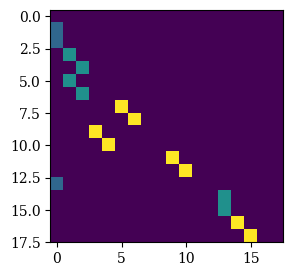

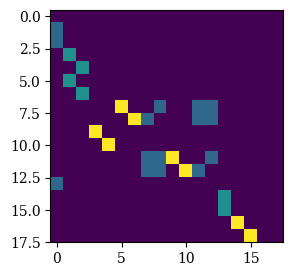

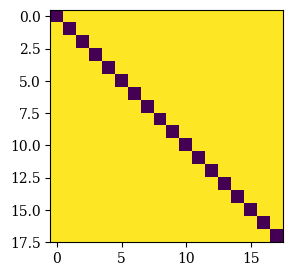

In [5]:
for ei in [PHYS_EDGE_INDEX, COORD_EDGE_INDEX, FC_EDGE_INDEX]:
    edge_index = torch.tensor(ei)
    aagcn_graph = Graph(edge_index, N)
    original_graph = np.array(aagcn_graph.A)
    
    plt.figure(figsize=(3, 3.5))
    plt.imshow((original_graph[2]))
    plt.show()

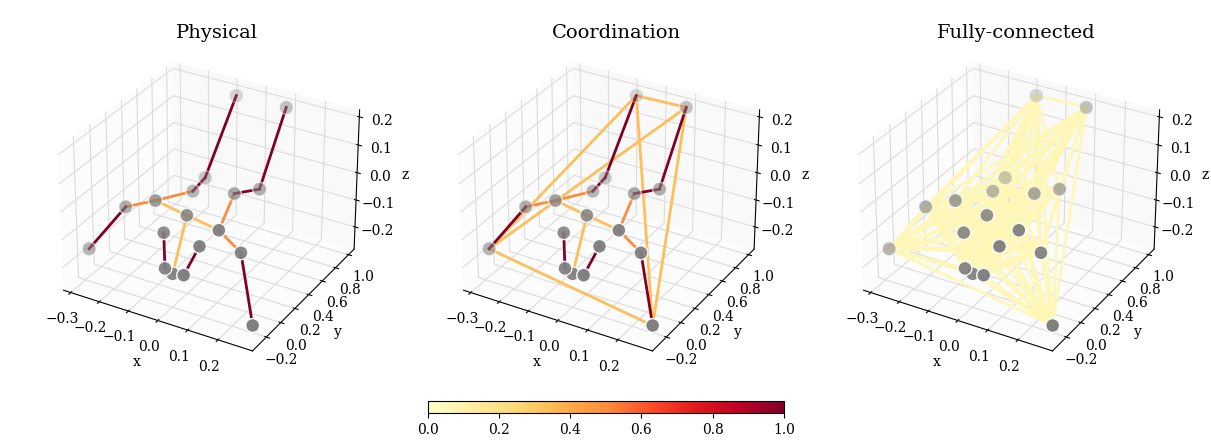

In [6]:
def plot_learned_graph_3d(ax, A, mean_sample, cmap=plt.cm.YlOrRd, norm=None):
    G = nx.Graph()
    
    for i in range(A.shape[0]):
        G.add_node(i)
    
    for i in range(A.shape[0]):
        for j in range(i + 1, A.shape[1]):
            if A[i, j] > 0:
                G.add_edge(i, j, weight=A[i, j])
            if A[j, i] > 0:
                G.add_edge(j, i, weight=A[j, i])
    
    # Get the positions for each node (x, y, z from sample data)
    pos = {NODE_INDEX[str(i)]: (mean_sample[f'{i}_x'], 
                                mean_sample[f'{i}_y'], 
                                mean_sample[f'{i}_z']) for i in NODE_INDEX}
    
    node_xyz = np.array([pos[v] for v in sorted(G)])
    edge_xyz = np.array([(pos[u], pos[v]) for u, v in G.edges()])
    edge_weights = np.array([G[u][v]['weight'] for u, v in G.edges()])

    # Normalize the edge weights
    if norm is None:
        norm = plt.Normalize(vmin=0, vmax=1)
    normed_weights = norm(edge_weights)

    # Plot nodes
    ax.scatter(*node_xyz.T, s=100, ec='w', c='gray')

    # Plot edges with color from colormap based on normalized weights
    for i, edge in enumerate(edge_xyz):
        ax.plot(*edge.T, color=cmap(normed_weights[i]), lw=2, zorder=normed_weights[i])

    # Format axes
    ax.xaxis.pane.set_facecolor('#FBFBFB')
    ax.yaxis.pane.set_facecolor('#F4F4F4')
    ax.zaxis.pane.set_facecolor('#FBFBFB')

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')

    ax.xaxis.pane.set_edgecolor('none')
    ax.yaxis.pane.set_edgecolor('none')
    ax.zaxis.pane.set_edgecolor('none')

    ax.grid(True)
    grid_color = '#DCDCDC'
    ax.xaxis._axinfo["grid"].update(color=grid_color, linestyle='-')
    ax.yaxis._axinfo["grid"].update(color=grid_color, linestyle='-')
    ax.zaxis._axinfo["grid"].update(color=grid_color, linestyle='-')
    
    #ax.set_xlabel('')  # Remove x-axis label
    #ax.set_ylabel('')  # Remove y-axis label
    #ax.set_zlabel('')  # Remove z-axis label


fig, axs = plt.subplots(1, 3, figsize=(12, 4.4), subplot_kw={'projection': '3d'}, constrained_layout=True)

df = pd.read_csv(os.path.join('data', 'rotated', 'helsinki', 'v63_1_9.csv'))
mean_sample = df.mean()

titles = ['Physical', 'Coordination', 'Fully-connected']

for idx, ei in enumerate([PHYS_EDGE_INDEX, COORD_EDGE_INDEX, FC_EDGE_INDEX]):
    edge_index = torch.tensor(ei)
    aagcn_graph = Graph(edge_index, N, normalize=True)
    original_graph = np.array(aagcn_graph.A)[2]
    plot_learned_graph_3d(axs[idx], original_graph, mean_sample)

    axs[idx].text(1.95, 1.15, 4.43, s=titles[idx], transform=axs[idx].transAxes, fontsize=14, ha='center')
    axs[idx].set_box_aspect(aspect=None, zoom=0.86)
    
    #axs[idx].xaxis.set_tick_params(which='both', labelbottom=False)
    #axs[idx].yaxis.set_tick_params(which='both', labelleft=False)
    #axs[idx].zaxis.set_tick_params(which='both', labelleft=False)

cbar = fig.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(0, 1), cmap=plt.cm.YlOrRd), 
                        ax=axs, orientation='horizontal', aspect=30, fraction=0.03, pad=0)

for ext in ['png', 'pdf']:
    plt.savefig(f'figures/inits.{ext}', dpi=300, bbox_inches='tight')
plt.show()

## Store Global Graphs

In [25]:
def extract_learned_graph_weights(model):
    learned_graphs = []

    for layer in model.children():
        if isinstance(layer, AAGCN):
            learned_graphs.append(layer.A.detach().cpu().numpy())
            
    return learned_graphs

In [26]:
age_data = pd.read_csv('metadata/combined.csv', dtype={'test_id': str})
fts_data = pd.read_csv('data/features.csv')

num_folds = 10

model_names = ['aagcn', 'aagcn-coord', 'aagcn-fc']

global_graphs = {}

for model_name in model_names:
    adjacency_matrices_sum = None
    
    for fold in tqdm(range(1, num_folds + 1)):
        output_dir = os.path.join('results', model_name, f'fold_{fold}')
        with open(os.path.join(output_dir, 'metadata.json'), 'r') as f:
            metadata = json.load(f)

        args = metadata['args']

        streams = args['streams'].split(',')
        xy_data = metadata['args']['xy_data']

        if metadata['args']['edges'] == 'phys':
            edge_index = torch.tensor(PHYS_EDGE_INDEX)
        if metadata['args']['edges'] == 'coord':
            edge_index = torch.tensor(COORD_EDGE_INDEX)
        if metadata['args']['edges'] == 'fc':
            edge_index = torch.tensor(FC_EDGE_INDEX)

        model = AdaptiveSTGCN.load_from_checkpoint(
            checkpoint_path=f'{output_dir}/best_model.ckpt',
            in_channels=2*len(streams) if xy_data else 3*len(streams),
            edge_index=edge_index,
            num_nodes=N,
            learning_rate=args['learning_rate'],
            adaptive=args['adaptive'],
            attention=args['attention'],
            masking=args['masking'],
            concat_features=args['concat_features'],
            kt=args['kt'],
            hidden_dim=args['hidden_dim'],
            store_graphs=True,
            store_attention=True,
        )
        model.eval()

        # Extract learned adjacency matrices
        learned_graphs = extract_learned_graph_weights(model)

        # Initialize adjacency_matrices_sum if it's the first fold
        if adjacency_matrices_sum is None:
            adjacency_matrices_sum = [np.zeros_like(graph) for graph in learned_graphs]

        # Sum up adjacency matrices
        for i in range(len(learned_graphs)):
            adjacency_matrices_sum[i] += learned_graphs[i]

    # Compute the average adjacency matrices
    average_learned_graphs = [matrix / num_folds for matrix in adjacency_matrices_sum]
    
    aagcn_graph = Graph(edge_index, N)
    original_graph = np.array(aagcn_graph.A)
    
    global_graphs[model_name] = {
        'original': original_graph,
        'learned': average_learned_graphs,
    }
    
output_file = os.path.join('results', 'global_graphs.npz')
np.savez(output_file, **global_graphs)
print(f"Saved global_graphs to {output_file}")

  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib64/python3.9/site-packages/torch/cuda/__init__.py:628: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Saved global_graphs to results/global_graphs.npz


## Store Complete Graphs

In [27]:
num_folds = 10
num_samples = 0
times = []

model_names = ['aagcn', 'aagcn-coord', 'aagcn-fc']

complete_graphs = {}

# KFold to generate train and validation indices
kfold = KFold(n_splits=num_folds, shuffle=False)

num_layers = 3  # 3 layers
num_matrices = 3  # Self-loop (0), outward (1), inward (2)


for model_name in model_names:
    accumulated_graphs = [np.zeros((num_matrices, len(NODE_INDEX), len(NODE_INDEX))) for _ in range(num_layers)]
    num_samples = 0

    # Iterate through the KFold validation
    for fold, (train_indices, val_indices) in enumerate(kfold.split(age_data), start=1):
        val_ids = age_data.iloc[val_indices].test_id.values
        val_fts = fts_data[fts_data['test_id'].isin(val_ids)]

        # Load the model for the current fold
        output_dir = f'results/{model_name}/fold_{fold}'
        with open(os.path.join(output_dir, 'metadata.json'), 'r') as f:
            metadata = json.load(f)

        args = metadata['args']
        streams = args['streams'].split(',')
        xy_data = metadata['args']['xy_data']
        
        # Create dataset and dataloader for validation set
        val_dataset = InfantMotionDataset(args['data_dir'], val_fts, streams, xy_data=xy_data, predict=True)
        val_loader = DataLoader(val_dataset, batch_size=1, num_workers=1)

        if metadata['args']['edges'] == 'phys':
            edge_index = torch.tensor(PHYS_EDGE_INDEX)
        if metadata['args']['edges'] == 'coord':
            edge_index = torch.tensor(COORD_EDGE_INDEX)
        if metadata['args']['edges'] == 'fc':
            edge_index = torch.tensor(FC_EDGE_INDEX)

        model = AdaptiveSTGCN.load_from_checkpoint(
            checkpoint_path=f'{output_dir}/best_model.ckpt',
            in_channels=2*len(streams) if xy_data else 3*len(streams),
            edge_index=edge_index,
            num_nodes=len(NODE_INDEX),
            learning_rate=args['learning_rate'],
            adaptive=args['adaptive'],
            attention=args['attention'],
            masking=args['masking'],
            concat_features=args['concat_features'],
            kt=args['kt'],
            hidden_dim=args['hidden_dim'],
            store_graphs=True,
            store_attention=True,
        )
        model.eval()

        # Make predictions on the validation set for the current fold
        for i, batch in tqdm(enumerate(val_loader), total=len(val_loader), desc=f'Fold {fold}'):
            with torch.no_grad():
                X, y, fts = batch
                y_pred = model(X, fts)

                # Sum the learned graphs for this sample
                for layer_num in range(num_layers):  # Assuming 3 layers
                    layer = getattr(model, f'l{layer_num + 1}')
                    learned_graphs = layer.learned_graphs  # Get the learned graphs for the layer

                    for n in range(num_matrices):  # 3 types of edges: self, inward, outward
                        accumulated_graphs[layer_num][n] += learned_graphs[n].squeeze()

                num_samples += 1

    # Compute the average adjacency matrices
    average_graphs = [layer_graph / num_samples for layer_graph in accumulated_graphs]

    # Plot the average learned adjacency matrices for each layer
    aagcn_graph = Graph(edge_index, len(NODE_INDEX))
    original_graph = np.array(aagcn_graph.A).squeeze()


    complete_graphs[model_name] = {
        'original': original_graph,
        'learned': average_graphs,
    }

output_file = os.path.join('results', 'complete_graphs.npz')
np.savez(output_file, **complete_graphs)
print(f"Saved global_graphs to {output_file}")

Fold 1:   0%|          | 0/161 [00:00<?, ?it/s]

Fold 2:   0%|          | 0/202 [00:00<?, ?it/s]

Fold 3:   0%|          | 0/206 [00:00<?, ?it/s]

Fold 4:   0%|          | 0/173 [00:00<?, ?it/s]

Fold 5:   0%|          | 0/194 [00:00<?, ?it/s]

Fold 6:   0%|          | 0/164 [00:00<?, ?it/s]

Fold 7:   0%|          | 0/187 [00:00<?, ?it/s]

Fold 8:   0%|          | 0/182 [00:00<?, ?it/s]

Fold 9:   0%|          | 0/205 [00:00<?, ?it/s]

Fold 10:   0%|          | 0/169 [00:00<?, ?it/s]

Fold 1:   0%|          | 0/161 [00:00<?, ?it/s]

Fold 2:   0%|          | 0/202 [00:00<?, ?it/s]

Fold 3:   0%|          | 0/206 [00:00<?, ?it/s]

Fold 4:   0%|          | 0/173 [00:00<?, ?it/s]

Fold 5:   0%|          | 0/194 [00:00<?, ?it/s]

Fold 6:   0%|          | 0/164 [00:00<?, ?it/s]

Fold 7:   0%|          | 0/187 [00:00<?, ?it/s]

Fold 8:   0%|          | 0/182 [00:00<?, ?it/s]

Fold 9:   0%|          | 0/205 [00:00<?, ?it/s]

Fold 1:   0%|          | 0/161 [00:00<?, ?it/s]

Fold 2:   0%|          | 0/202 [00:00<?, ?it/s]

Fold 3:   0%|          | 0/206 [00:00<?, ?it/s]

Fold 4:   0%|          | 0/173 [00:00<?, ?it/s]

Fold 5:   0%|          | 0/194 [00:00<?, ?it/s]

Fold 6:   0%|          | 0/164 [00:00<?, ?it/s]

Fold 7:   0%|          | 0/187 [00:00<?, ?it/s]

Fold 8:   0%|          | 0/182 [00:00<?, ?it/s]

Fold 9:   0%|          | 0/205 [00:00<?, ?it/s]

Fold 10:   0%|          | 0/169 [00:00<?, ?it/s]

Saved global_graphs to results/complete_graphs.npz


## Load Graphs

In [7]:
loaded_data = np.load('results/global_graphs.npz', allow_pickle=True)
global_graphs = {model_name: loaded_data[model_name].item() for model_name in loaded_data.files}
print(global_graphs.keys())

dict_keys(['aagcn', 'aagcn-coord', 'aagcn-fc'])


In [8]:
loaded_data = np.load('results/complete_graphs.npz', allow_pickle=True)
complete_graphs = {model_name: loaded_data[model_name].item() for model_name in loaded_data.files}
print(complete_graphs.keys())

dict_keys(['aagcn', 'aagcn-coord', 'aagcn-fc'])


## Plot global learned matrices

In [23]:
def plot_adjacency_matrix(fig, ax, A, label_letter, matrix_type, layer_num, add_xlabel, add_ylabel):
    cmap = 'coolwarm' if matrix_type == 'residual' else 'viridis'
    
    if matrix_type == 'residual':
        vmin = np.min(A)
        vmax = np.max(A)
        abs_max = max(abs(vmin), abs(vmax))
        vmin, vmax = -abs_max, abs_max
    else:
        vmin, vmax = None, None

    cax = ax.matshow(A, cmap=cmap, interpolation='none', vmin=vmin, vmax=vmax)
    
    cbar = fig.colorbar(cax, ax=ax, fraction=0.0452, pad=0.05)
    cbar.ax.tick_params(labelsize=12)
    
    if add_xlabel:
        labels = list(NODE_INDEX.keys())
        ax.set_xticks(range(len(labels)))
        ax.set_xticklabels(labels, rotation=90, fontsize=12)
        ax.tick_params(axis='x', bottom=False)
    else:
        ax.set_xticks([])

    if add_ylabel:
        labels = list(NODE_INDEX.keys())
        ax.set_yticks(range(len(labels)))
        ax.set_yticklabels(labels, fontsize=14)
    else:
        ax.set_yticks([])

    if matrix_type == 'original':
        axis_text = f'({label_letter}) Original adjacency matrix'
    elif matrix_type == 'learned':
        axis_text = f'({label_letter}) Layer {layer_num+1} adjacency matrix'
    else:
        axis_text = f'({label_letter}) Layer {layer_num+1} residual matrix'

    ax.text(0.05, -0.085, axis_text, transform=ax.transAxes, fontsize=16)

Plotting adjacency matrices for model: aagcn
Plotting adjacency matrix type 0


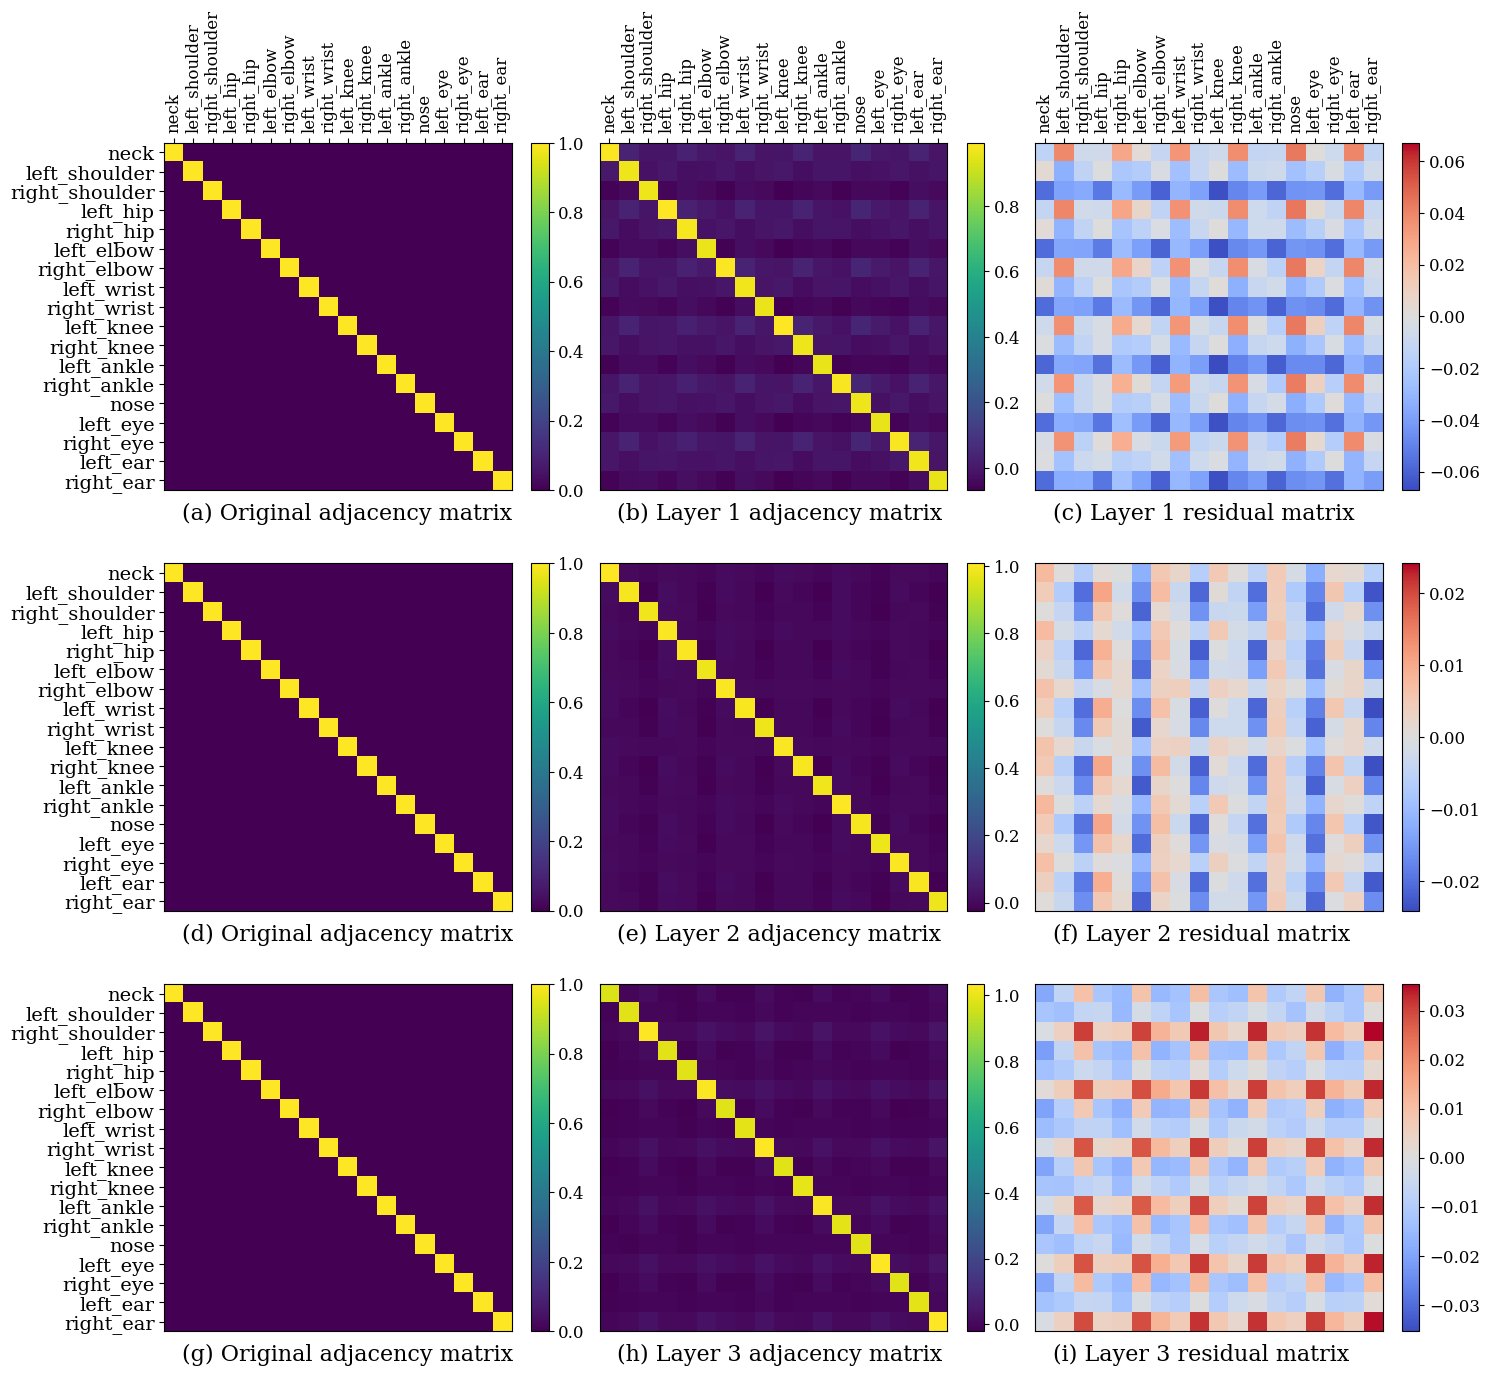

Plotting adjacency matrix type 1


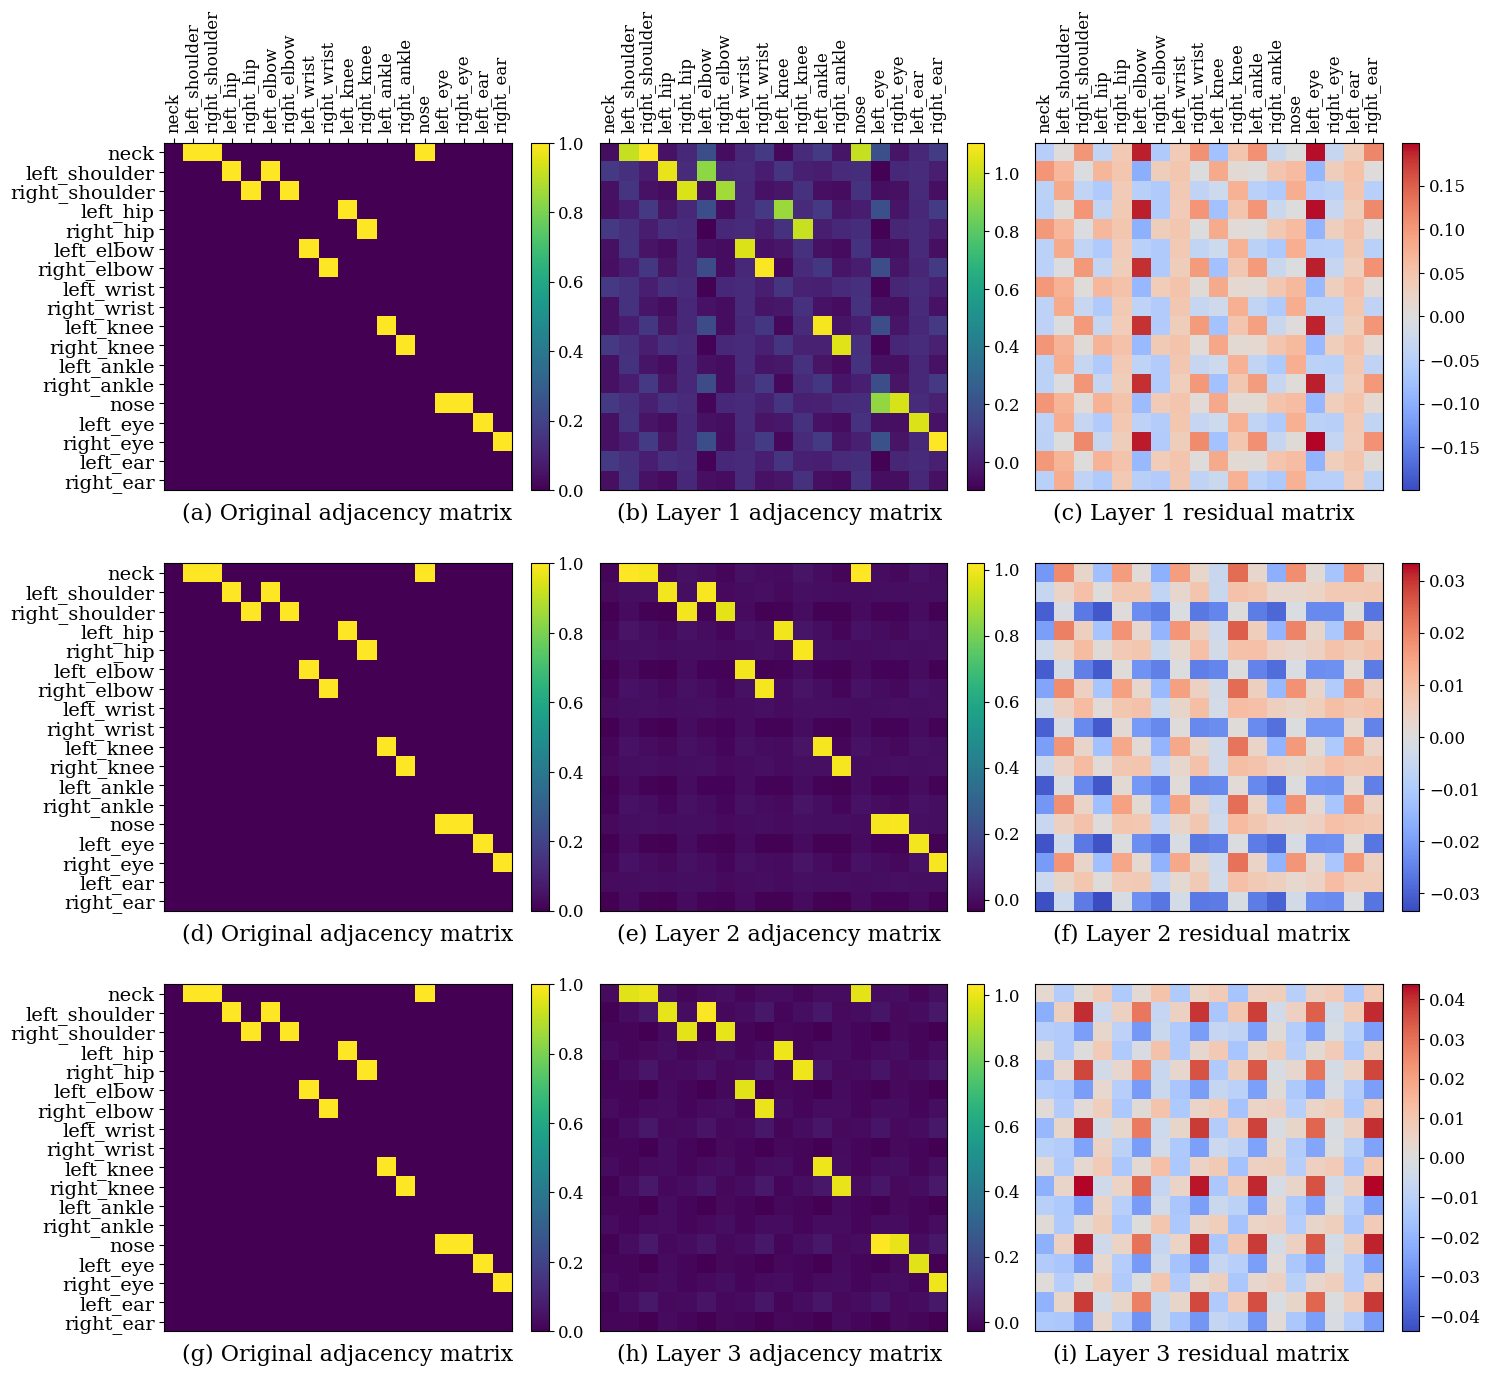

Plotting adjacency matrix type 2


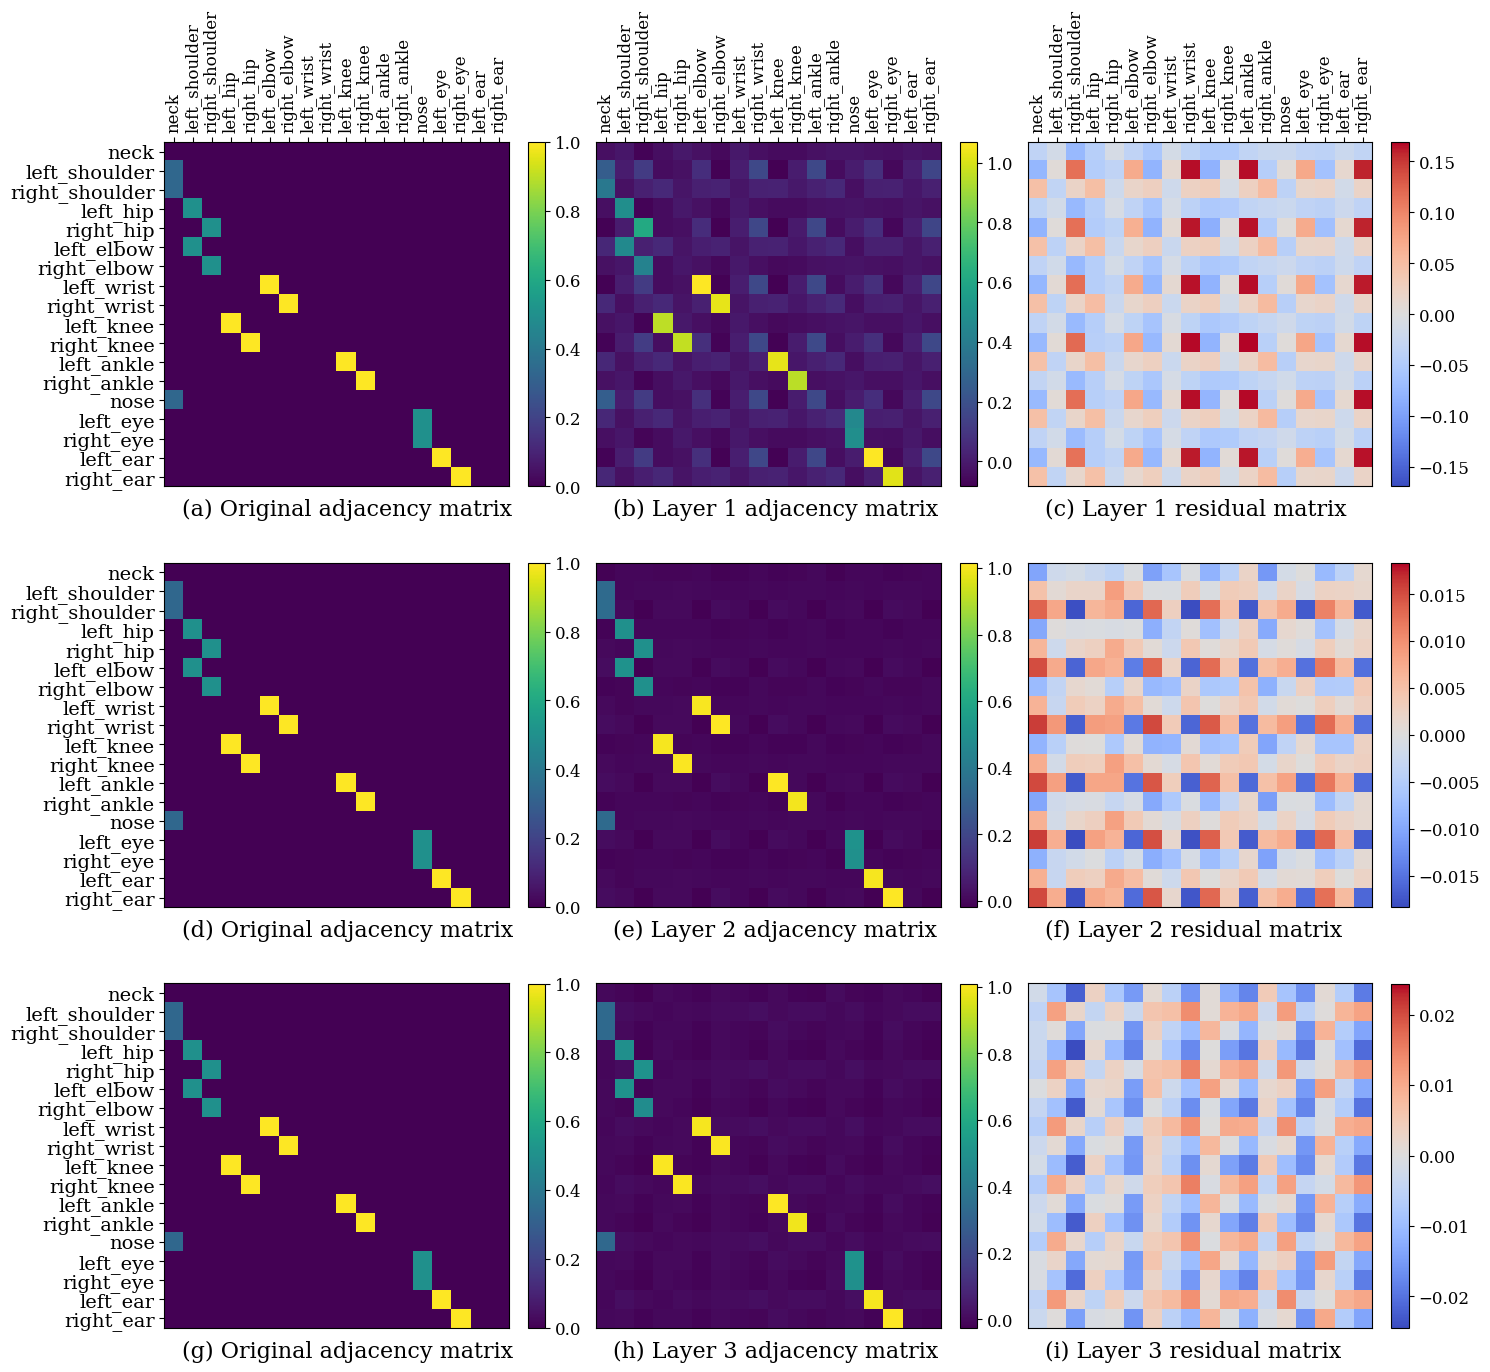

In [24]:
def plot_model_adjacency_matrices(model_name, global_graphs):
    print(f"Plotting adjacency matrices for model: {model_name}")
    
    original_graph = global_graphs[model_name]['original']
    learned_graphs = global_graphs[model_name]['learned']
    
    # Loop through adjacency matrices
    for n in range(3):
        print(f"Plotting adjacency matrix type {n}")
    
        fig, axs = plt.subplots(3, 3, figsize=(15, 15))

        for i in range(len(learned_graphs)):

            # Original Graph for each layer
            label_letter = string.ascii_lowercase[i * 3]
            plot_adjacency_matrix(fig, axs[i, 0], original_graph[n, :, :], label_letter, 'original', i, add_xlabel=(i == 0), add_ylabel=True)

            # Averaged Learned Graph for each layer
            label_letter = string.ascii_lowercase[i * 3 + 1]
            plot_adjacency_matrix(fig, axs[i, 1], learned_graphs[i][n, :, :], label_letter, 'learned', i, add_xlabel=(i == 0), add_ylabel=False)

            # Residual for each layer with coolwarm colormap
            label_letter = string.ascii_lowercase[i * 3 + 2]
            diff = learned_graphs[i][n, :, :] - original_graph[n, :, :]
            plot_adjacency_matrix(fig, axs[i, 2], diff, label_letter, 'residual', i, add_xlabel=(i == 0), add_ylabel=False)

        plt.tight_layout()
        fig.subplots_adjust(hspace=-0.15)
        
        #for ext in ['png', 'pdf', 'eps']:
        #    plt.savefig(f'figures/averaged_adjacency_matrices.{ext}', dpi=300)

        # Show the plot
        plt.show()

plot_model_adjacency_matrices('aagcn', global_graphs)

In [11]:
# Build a graph from a learned adjacency matrix
def get_graph_from_adjacency(A, skip_zero_edges=False):
    G = nx.Graph()
    
    # Add nodes to the graph
    for bodypart in NODE_INDEX.keys():
        G.add_node(NODE_INDEX[bodypart], label=bodypart)
    
    # Add edges to the graph with weights
    for i, label_0 in enumerate(NODE_INDEX.keys()):
        for j, label_1 in enumerate(NODE_INDEX.keys()):
            weight = A[i, j]
            if not skip_zero_edges or weight > 0:  # Skip edges with weight == 0 only for original graph
                G.add_edge(NODE_INDEX[label_0], NODE_INDEX[label_1], weight=weight)
    
    return G

# Plot a 3D graph from learned adjacency matrix
def plot_learned_graph_3d(ax, A, mean_sample, cmap=plt.cm.YlOrRd, norm=None, skip_zero_edges=False):
    G = get_graph_from_adjacency(A, skip_zero_edges=skip_zero_edges)
    
    # Get the positions for each node (x, y, z from sample data)
    pos = {NODE_INDEX[bodypart]: (mean_sample[f'{bodypart}_x'], 
                                  mean_sample[f'{bodypart}_y'], 
                                  mean_sample[f'{bodypart}_z']) for bodypart in NODE_INDEX}
    
    node_xyz = np.array([pos[v] for v in sorted(G)])
    edge_xyz = np.array([(pos[u], pos[v]) for u, v in G.edges()])

    # Get the edge weights
    edge_weights = np.array([G[u][v]['weight'] for u, v in G.edges()])
    
    # Normalize edge weights based on provided vmin and vmax
    normed_weights = norm(edge_weights)

    # Plot nodes
    ax.scatter(*node_xyz.T, s=100, ec='w', c='gray')

    # Plot edges, color based on normalized weights
    for i, vizedge in enumerate(edge_xyz):
        ax.plot(*vizedge.T, color=cmap(normed_weights[i]), lw=2, zorder=edge_weights[i])

    def _format_axes(ax):
        
        ax.xaxis.pane.set_facecolor('#FBFBFB')
        ax.yaxis.pane.set_facecolor('#F4F4F4')
        ax.zaxis.pane.set_facecolor('#FBFBFB')
        
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')
        
        ax.xaxis.pane.set_edgecolor('none')
        ax.yaxis.pane.set_edgecolor('none')
        ax.zaxis.pane.set_edgecolor('none')


        ax.grid(True)
        grid_color = '#DCDCDC'
        
        ax.xaxis._axinfo["grid"].update(color=grid_color, linestyle='-')
        ax.yaxis._axinfo["grid"].update(color=grid_color, linestyle='-')
        ax.zaxis._axinfo["grid"].update(color=grid_color, linestyle='-')
    
    _format_axes(ax)

def normalize_model_weights(graphs):
    all_weights = []
    
    all_weights.extend(graphs['original'][2].flatten())
    for learned in graphs['learned']:
        all_weights.extend(learned[2].flatten())
    
    all_weights = np.array(all_weights)
    all_weights = all_weights[all_weights > 0]  # Exclude zero weights

    min_weight = np.min(all_weights)
    max_weight = np.max(all_weights)

    return plt.Normalize(vmin=min_weight, vmax=max_weight)

# Plot combined original and learned graphs across models and layers
def plot_combined_3d_graphs(global_graphs, models, model_labels, mean_sample, partition=2):
    print("Plotting combined original and learned graphs for three models")

    fig, axs = plt.subplots(4, 3, figsize=(14, 18), subplot_kw={'projection': '3d'}, constrained_layout=True)
    
    layer_labels = ['Initialization', 'Layer 1', 'Layer 2', 'Layer 3']
    
    # Loop through models
    for col, model_name in enumerate(models):
        original_A = global_graphs[model_name]['original'][partition]
        learned_graphs = global_graphs[model_name]['learned']

        norm = normalize_model_weights(global_graphs[model_name])

        # Plot original graph (first row)
        plot_learned_graph_3d(axs[0, col], original_A, mean_sample, cmap=plt.cm.YlOrRd, norm=norm, skip_zero_edges=True)
        
        # Loop through layers
        for row in range(1, 4):
            learned_A = learned_graphs[row-1][partition]  # Outward adjacency matrix (index 2 for layer)
            plot_learned_graph_3d(axs[row, col], learned_A, mean_sample, cmap=plt.cm.YlOrRd, norm=norm)

    for col, title in enumerate(model_labels):
        axs[0, col].set_title(title, fontsize=16)
    
    for row, label in enumerate(layer_labels):
        fig.text(0.0, 0.884 - row * 0.234, label, va='center', ha='center', rotation='vertical', fontsize=16)

    # Shared colorbar below all plots
    cbar = fig.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(0, 1), cmap=plt.cm.YlOrRd), 
                        ax=axs, orientation='horizontal', aspect=30, fraction=0.01, pad=0.03)
    cbar.ax.tick_params(labelsize=14)
    
    for ext in ['png', 'pdf', 'eps']:
        plt.savefig(f'figures/learned_graphs_{partition}.{ext}', dpi=300, bbox_inches='tight')

    plt.show()

df = pd.read_csv(os.path.join('data', 'rotated', 'helsinki', 'v63_1_9.csv'))
mean_sample = df.mean()  # Example node positions

models = ['aagcn', 'aagcn-coord', 'aagcn-fc']
model_labels = ['AAGCN', 'AAGCN coord', 'AAGCN fc']

Plotting combined original and learned graphs for three models


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


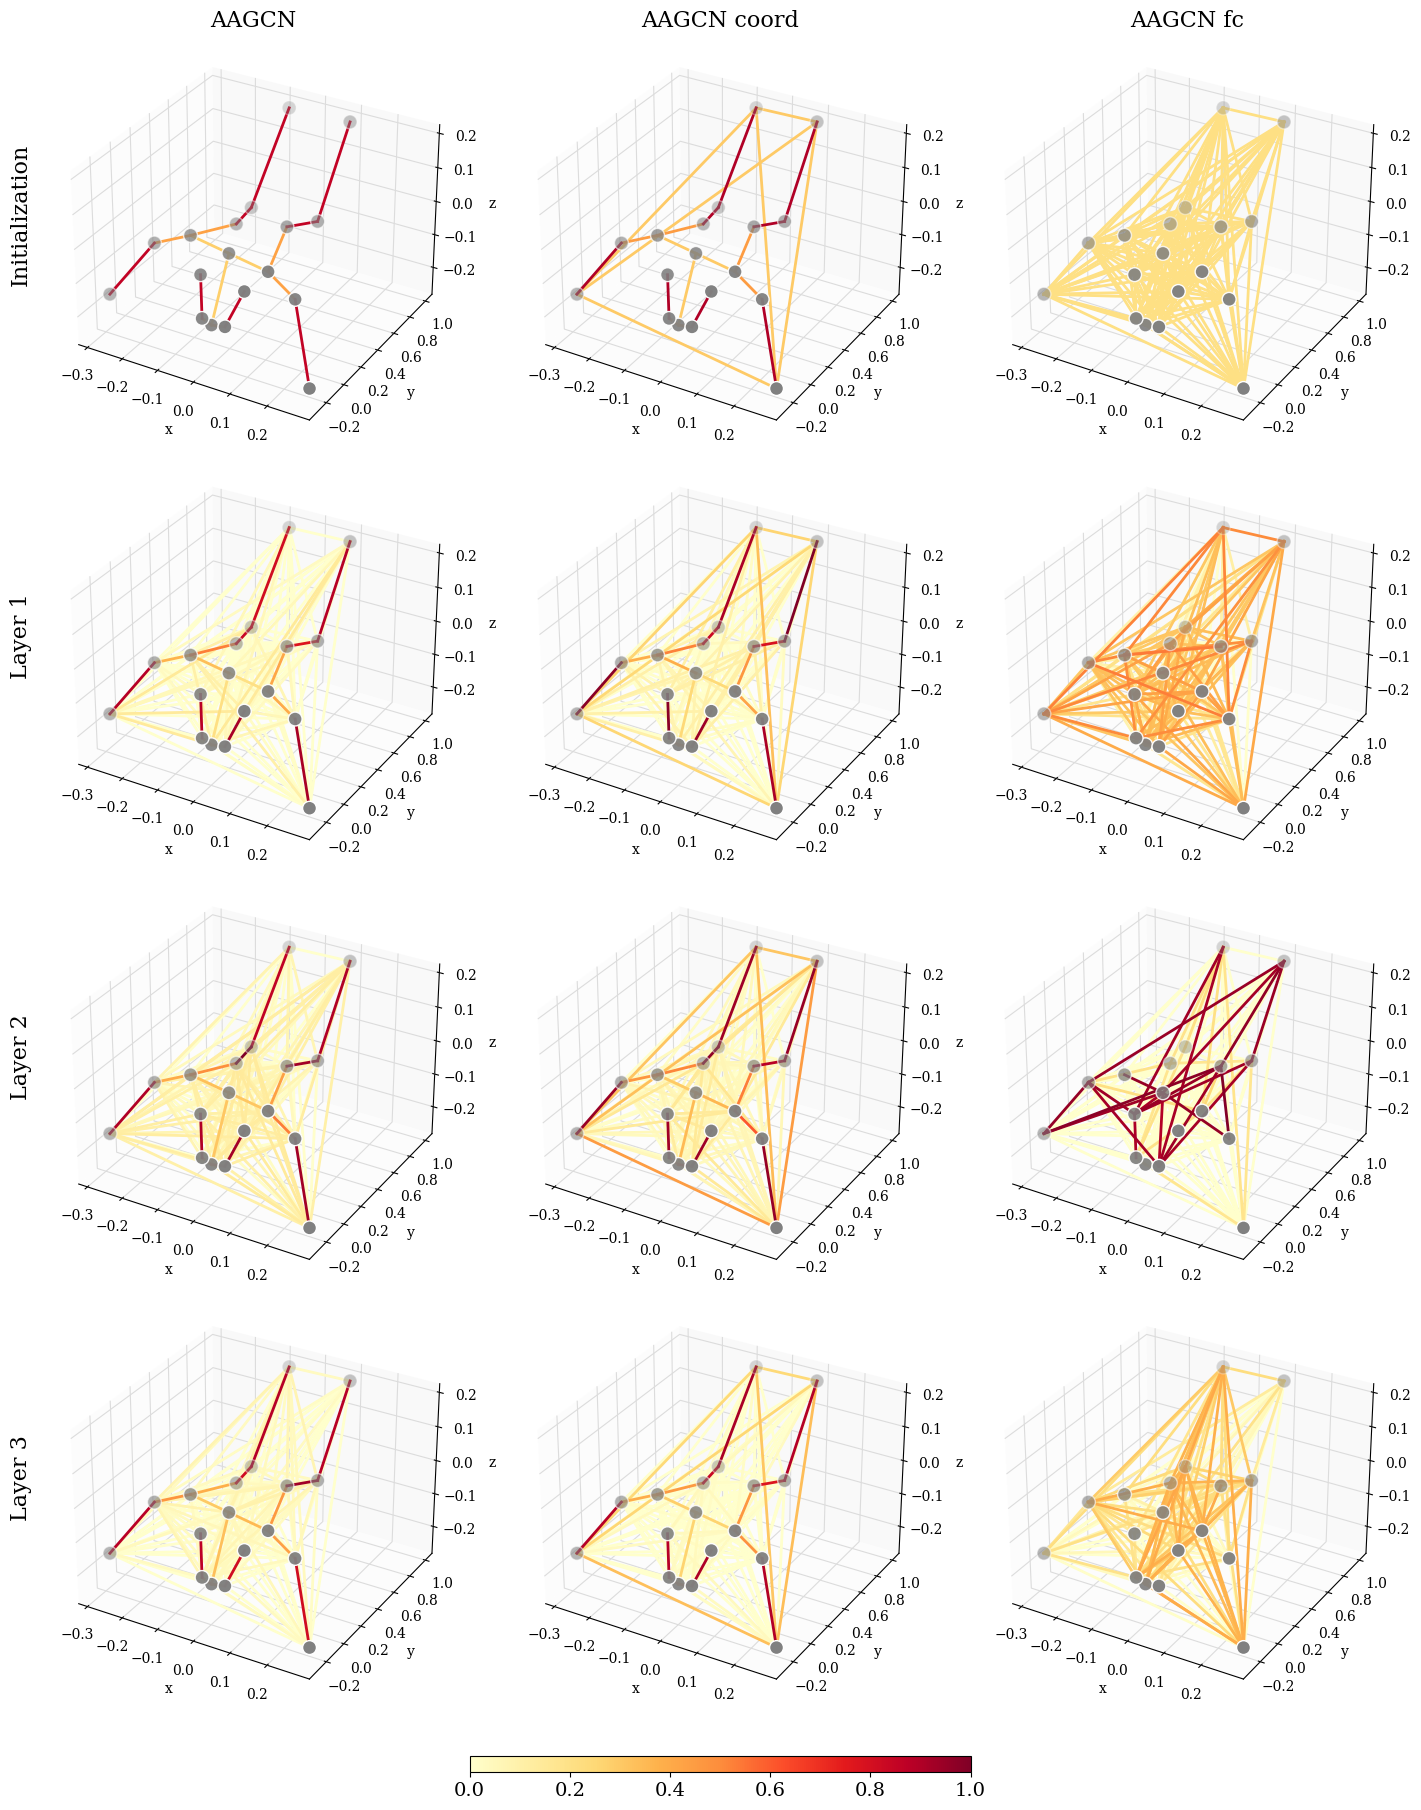

In [12]:
plot_combined_3d_graphs(complete_graphs, models, model_labels, mean_sample, 2)

Plotting combined original and learned graphs for three models


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


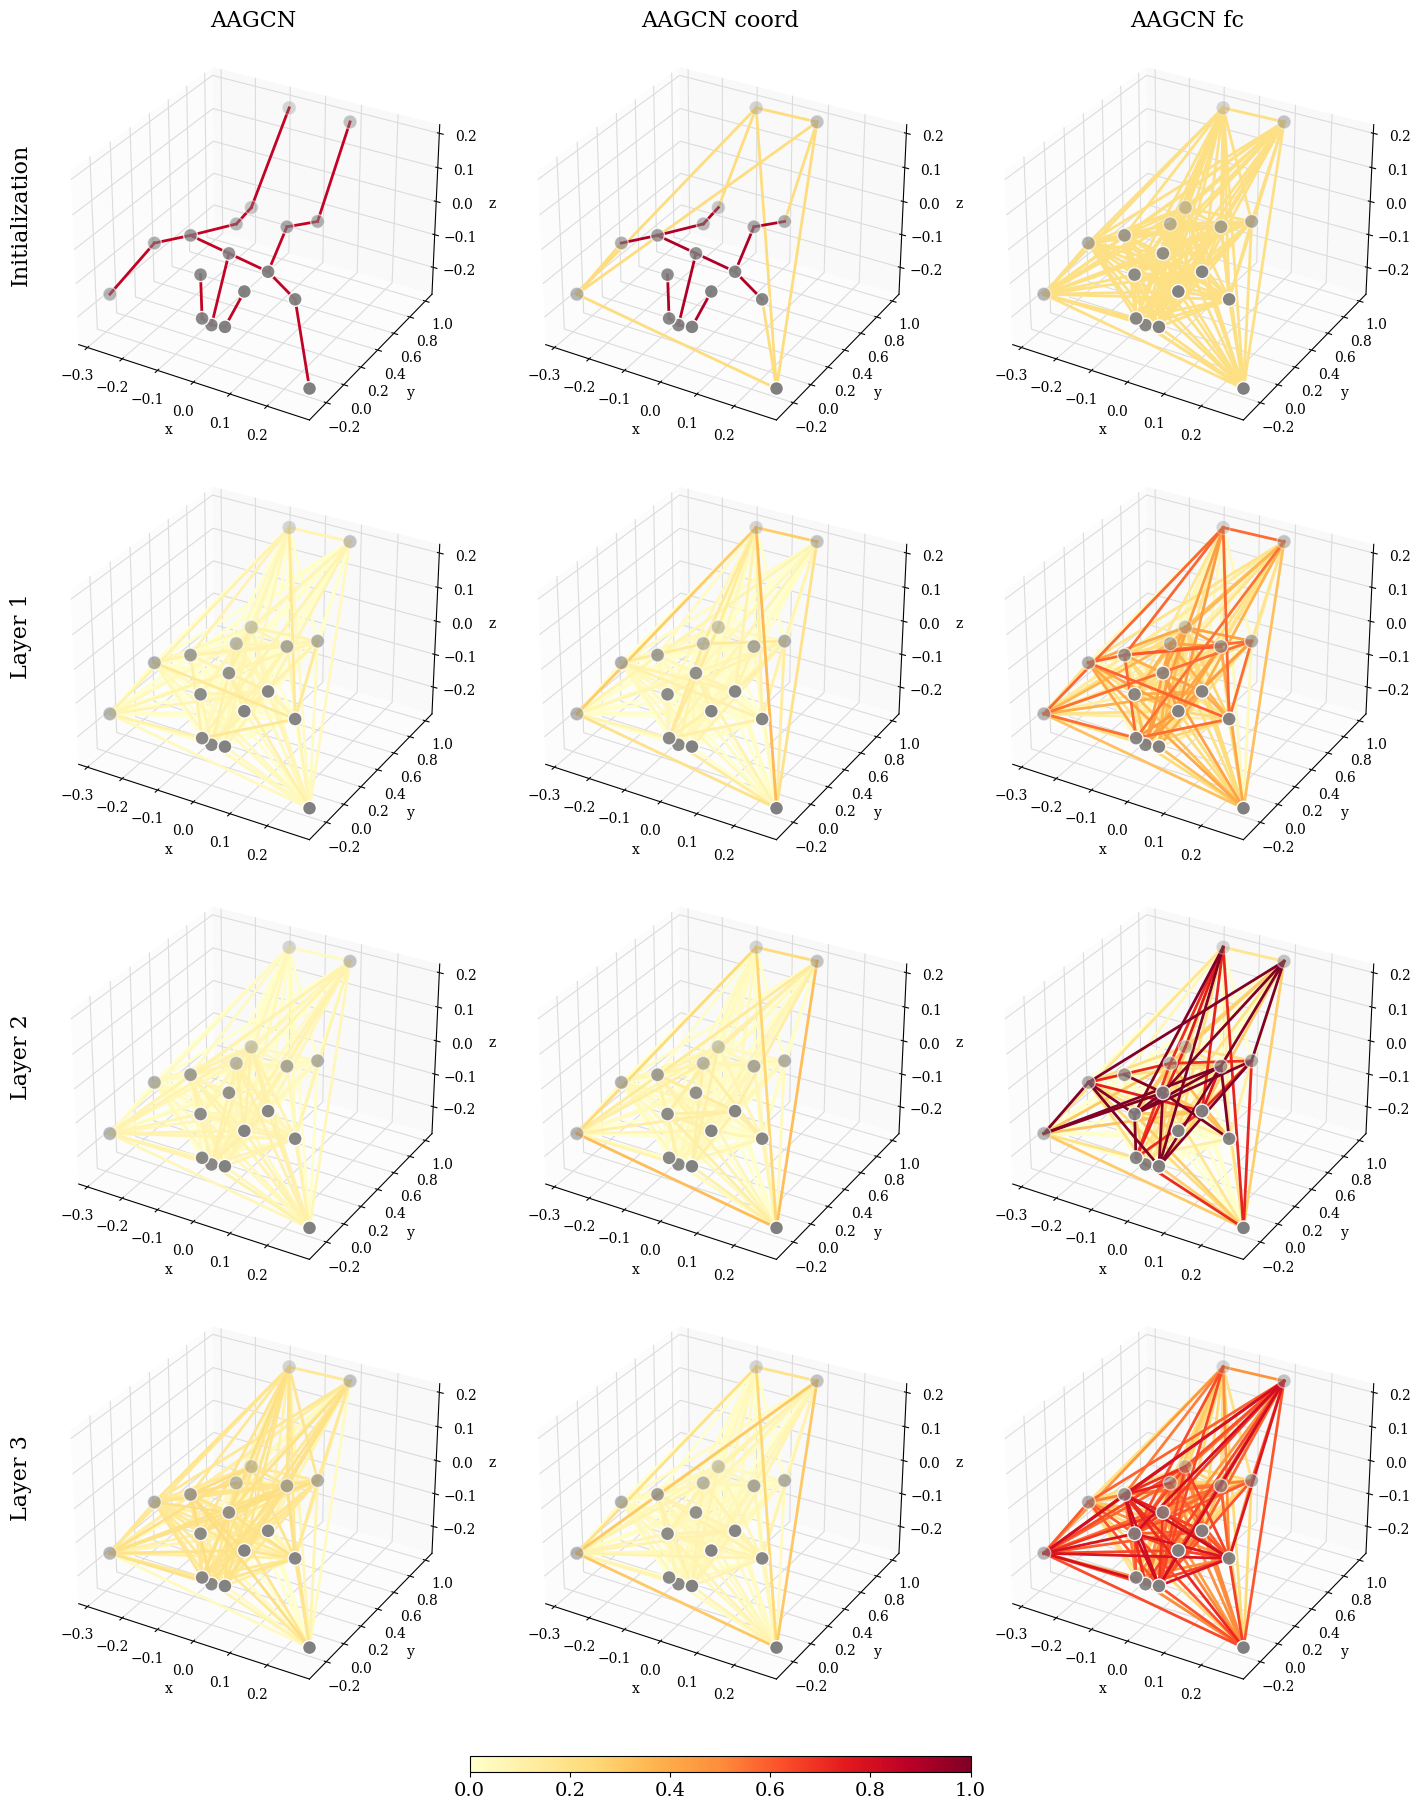

In [13]:
plot_combined_3d_graphs(complete_graphs, models, model_labels, mean_sample, 1)

Plotting combined original and learned graphs for three models


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


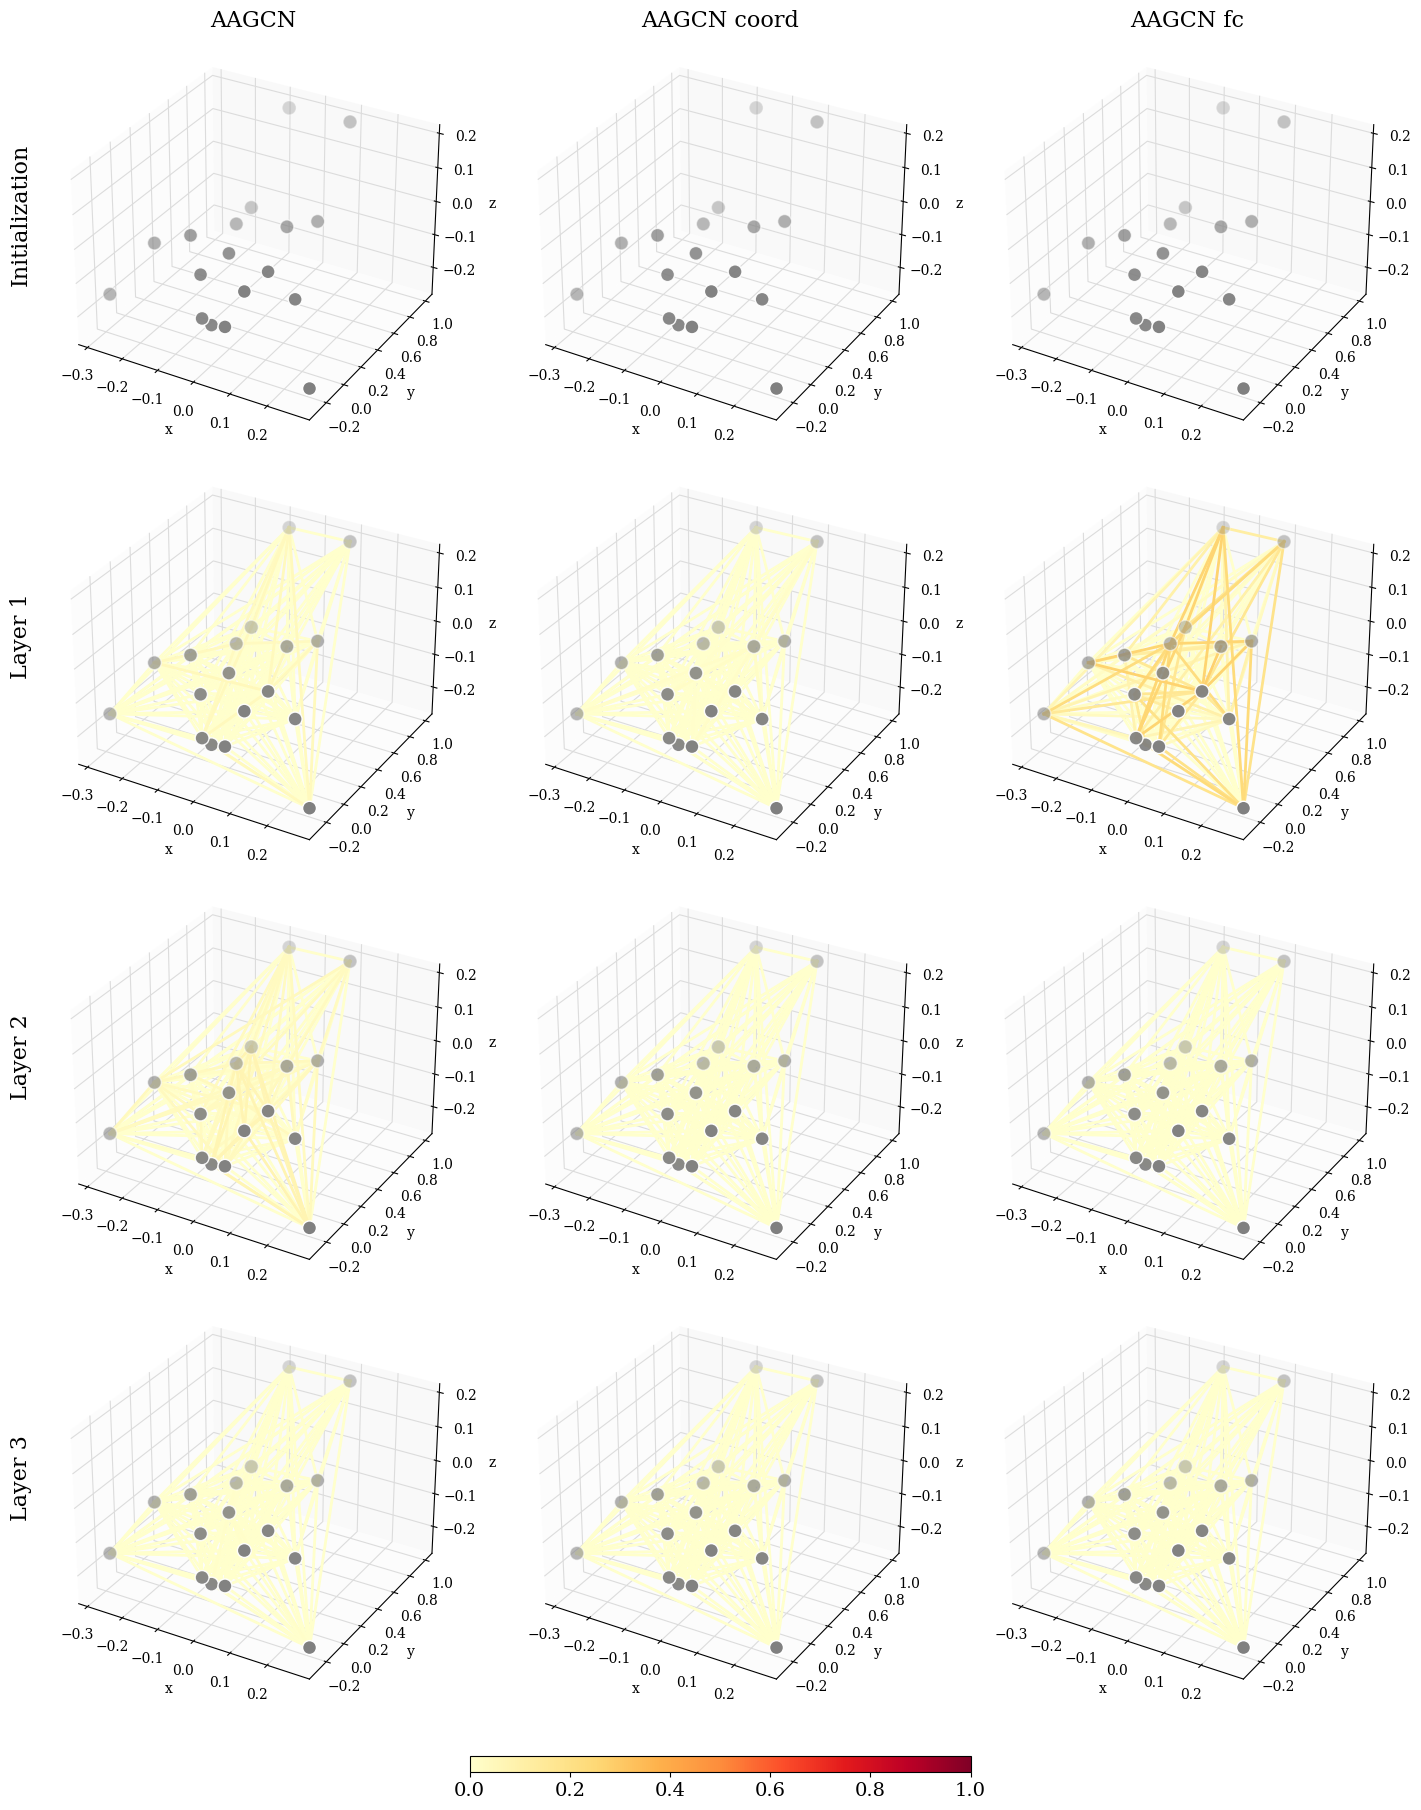

In [14]:
plot_combined_3d_graphs(complete_graphs, models, model_labels, mean_sample, 0)